# Introduction

The purpose of this hands-on session istwo-fold: 

 * Explaining how to evaluate a quasi-analytical solution, that is singular of the pressureless gas dynamics
 
 * Show that once the solution is becoming singular, the dynamics of the singularity is not the one of the original

# General setting and smooth solution

We consider the following Cauchy problem:

$\rho(t, \mathbf{x})$, $\mathbf{u}(t, \mathbf{x})$ satisfying

\begin{equation}
    \left\{
    \begin{aligned}
    \frac{\partial \rho}{\partial t} + \nabla \cdot (\rho \mathbf{u}) = 0 \\
    \frac{\partial \rho \mathbf{u}}{\partial t} + \nabla \cdot (\rho \mathbf{u} \mathbf{u} ) = 0
    \end{aligned}
    \right.
\end{equation}

with  $\rho(0, \mathbf{x}) = \rho_0(x) = 1$

\begin{equation}
    \left\{
        \begin{aligned}
            \mathbf{u}(0, x) = 0, \; x \in (-\infty, -1] \cup [-1, +\infty) \\
            \mathbf{u}(0, x) = 1 + x, \; x \in [-1, 0] \\
            \mathbf{u}(0, x) = 1 - x, \; x \in [0, 1]           
        \end{aligned}
    \right.    
\end{equation}

<IPython.core.display.Javascript object>


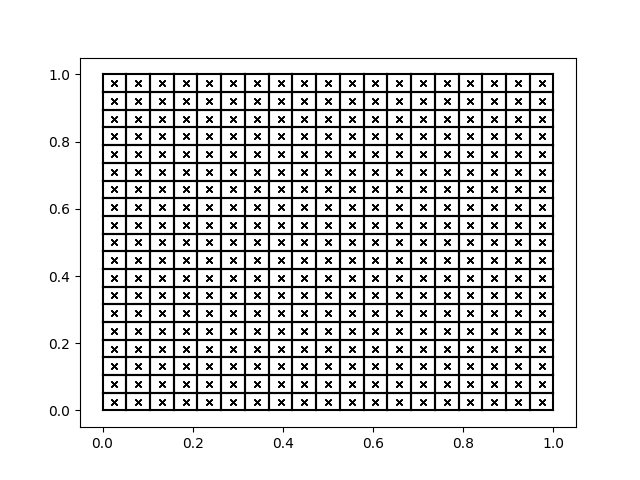

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

from josie.geom import CircleArc, Line
from josie.mesh import Mesh
from josie.bc import make_periodic, Direction

left = Line([0, 0], [0, 1])
# bottom = CircleArc([0, 0], [1, 0], [0.2, 0.2])
bottom = Line([0, 0], [1, 0])
right = Line([1, 0], [1, 1])
top = Line([0, 1], [1, 1])

left, right = make_periodic(left, right, Direction.X)
bottom, top = make_periodic(bottom, top, Direction.Y)

mesh = Mesh(left, bottom, right, top)
mesh.interpolate(20, 20)
mesh.generate()

mesh.plot()
plt.show()



In [2]:
import numpy as np

from josie.solver import Problem, StateTemplate, State, Solver
from josie.mesh import Cell

class Advection(Problem):
    Q = StateTemplate("u")
    V = np.array([1, 0])
    
    @classmethod
    def flux(cls, Q: State) -> State:
        return cls.V*Q
    
    
def init(cell: Cell) -> State: 
    xc, yc = cell.centroid
    
    if xc > 0.45:
        return Advection.Q(1)
    else:
        return Advection.Q(0)
    

    
def upwind(cell):
    Q = solver.problem.Q(0)
    for neigh in cell:
        norm = neigh.face.normal
        flux = Advection.flux
        S = neigh.face.surface

        un = Advection.V.dot(norm)

        if un >= 0:
            Q = Q + flux(cell.value).dot(norm)*S
        else:
            Q = Q + flux(neigh.value).dot(norm)*S

    return Q


solver = Solver(mesh, Advection)
solver.init(init)



<IPython.core.display.Javascript object>


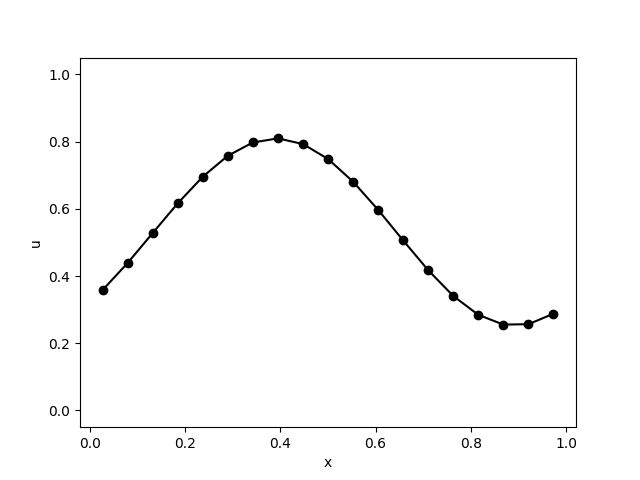

In [3]:
import matplotlib.animation as animation

dt = 0.01
fig = plt.figure()
plt.xlabel('x')
plt.ylabel('u')
ims = []
for i in range(100):
    solver.step(dt, upwind)
    
    # Pick one line
    data = [(np.array(cell.centroid), cell.value) for cell in solver.mesh.cells[:, -1]]
    data = np.asarray(data)  
    x = np.array([x  for x, y in data[:, 0] ])
    val = np.concatenate(data[:, 1])
    ims.append(plt.plot(x, val, 'ko-'))
    ani = animation.ArtistAnimation(fig, ims, interval=10)
ani


# Burgers Equation
The method of characteristics, provides a convenient way to calculate the evolution of both $\rho\left(t,\mathbf{x}\right)$ and $\mathbf{u}\left(t,\mathbf{x}\right)$.\\
The Burgers equation can be written as:
$$
\frac{\partial u}{\partial t}+ \frac{\partial}{\partial x}\left(\frac{u^2}{2}\right)=0
$$

That is the Burgers equation for which we know the solution. The density field becomes discontinuous but can be evaluated for all $t \in [0,1)$.\\
Anywhere on $\left(\left.-\infty,-1\right]\right. \cup \left[\left.1,+\infty\right)\right.$, we still have $\rho(t,\mathbf{x})=1 \forall t \in \left[\left. 0,1 \right) \right.$.\\
In the expansion wave, we have:
$$
\frac{D}{Dt}\log \rho = -\frac{\partial u}{\partial x} =\frac{-1}{1+t}
$$

so that:

$$
	\rho\left(t,x\right)=\frac{1}{1+t}
$$

with $t\in \left[0,1\right]$ and $x\in\left[t,1\right]$.\\
Considering the mass conservation equation, in the compression wave, we have:
$$
	\frac{D}{Dt}\log\rho = -\frac{\partial u}{\partial x}=\frac{1}{1-t}
$$

so that:

$$
	\rho(t,x)=\frac{1}{1-t}
$$

with $t\in\left[0,1\right]$ and $x\in\left[t,1\right]$. It clearely blows-up at $t=1$.


# The Rankine-Hugoniot generalized problem
We consider the typical singularity which can appear is a Delta shock, a shock in velocity, accompained with a Dirac delta function in density.\\
At time $t=1$, conserving mass and momentum allows to deduce that the amount of mass, which concentrate in the delta shock is:
$$
	\int_0^1\rho^0(x)\mathrm{d}x=1
$$

and the momentum:
$$
	\int_0^1\rho^0(x)u^0(x)\mathrm{d}x=\frac{1}{2}
$$

Thus we will start at $t=1$ by a solution given by the theory of characteristics anywhere in $x\in R\setminus\{1\}$ to which one "add" the following function:
$$
	m^1\delta\left(x-p^1\right)
$$
with:
$$
\begin{cases}
	m(1)=m^1=1\\
	p(1)=p^1=1\\
	v(1)=v^1=1
\end{cases}
$$

$m(t)$ represents the mass in the delta shock, $p(t)$ its position, $v(t)$ its velocity.\\

In order to resolve the dynamics of this singularity, we need generalized Rankine-Hugoniot jump conditions:


\begin{align*}
\begin{cases}
	\dfrac{d\rho(t)}{dt} &= v(t)\\
	\dfrac{d m(t)}{dt} &= -\left(\rho^{-}-\rho^{+}\right)v(t)+\rho^{-}u^{-}-\rho^{+}u^{+}\\
	\dfrac{d\left(m(t)v(t)\right)}{dt} &= -\left(\rho^{-}u^{-} -\rho^{+}u^{+}\right)v(t)+\rho^{-}\left(u^{-}\right)^2-\rho^{+}\left(u^{+}\right)^2
\end{cases}
\end{align*}

We will test two conditions:

## Condition 1

$$
\begin{align*}
\begin{cases}
    \rho^{+} &= 1\\
    \rho^{-} &=-\frac{1}{1+t}
\end{cases}
\end{align*}
$$
$$
\begin{align*}
\begin{cases}
    u^{+} &= 0\\
    u^{-} &=\frac{1+p(t)}{1+t}
\end{cases}
\end{align*}
$$

The system above will become:

\begin{align*}
\begin{cases}
	\dfrac{d\rho(t)}{dt} &= v(t)\\
	\dfrac{d m(t)}{dt} &= \frac{1}{1+t}\left(tv(t)+\frac{1+p(t)}{1+t}\right)\\
	\dfrac{d\left(m(t)v(t)\right)}{dt} &=\frac{1}{1+t}\left[\frac{1+p(t)}{1+t}-v(t)\right]^2-v(t)^2
\end{cases}
\end{align*}

## Condition 2

$$
\begin{align*}
\begin{cases}
    \rho^{+} &= 2\\
    \rho^{-} &=-\frac{1}{1+t}
\end{cases}
\end{align*}
$$
$$
\begin{align*}
\begin{cases}
    u^{+} &= 0\\
    u^{-} &=\frac{1+p(t)}{1+t}
\end{cases}
\end{align*}
$$

The system above will become:

\begin{align*}
\begin{cases}
	\dfrac{d\rho(t)}{dt} &= v(t)\\
	\dfrac{d m(t)}{dt} &= \frac{1}{1+t}\left(v(t)-\frac{1+p(t)}{1-t}\right)+2v(t)\\
	\dfrac{d\left(m(t)v(t)\right)}{dt} &=\left(\frac{1}{1+t}\right)\left(\frac{1+p(t)}{1+t}\right)\left[v-\frac{1+p(t)}{1+t}\right]
\end{cases}
\end{align*}